In [1]:
import datetime as dt
from pathlib import Path
from typing import Callable, List, Optional, Union, Sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import sunpy.data.sample
import sunpy.map
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
# from solarnet.data.sdo_benchmark_dataset import SDOBenchmarkDataset
# from solarnet.models.naive import naive_predictions_majority_class, naive_predictions_random_guess
from solarnet.utils.dict import print_dict
from solarnet.utils.metrics import classification_metrics
from solarnet.utils.target import flux_to_class_builder
import random
from pathlib import Path
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn, optim
# from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import confusion_matrix
from sunpy.net.vso import VSOQueryResponseTable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

from solarnet.utils.physics import id_to_class, flux_to_binary_class
from solarnet.utils.plots import plot_confusion_matrix, plot_image_grid

import boto3
from tqdm.notebook import tqdm
from solarnet.utils.yaml import load_yaml

import pl_bolts as B
# from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform, SimCLRTrainDataTransform)

import torchvision.transforms.functional as transforms_functional
from solarnet.data.dataset_utils import BaseDataset
from solarnet.data.transforms import SDOSimCLRDataTransform, sdo_dataset_normalize
from solarnet.data.sdo_dataset import SDODatasetDataModule
from solarnet.data.sdo_benchmark import SDOBenchmarkDataModule
from pl_bolts.transforms.self_supervised import Patchify, RandomTranslateWithReflect
from solarnet.utils.target import flux_to_class_builder
from solarnet.models.simclr import SimCLR
from solarnet.callbacks.ssl_online_evaluator import SSLOnlineEvaluator

from solarnet.models.backbone import get_backbone
from solarnet.models.image_classification import ImageClassification
import zarr
import dask.array as da
from datetime import datetime

/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io

In [2]:
t = torch.load("/home/jonathan.donzallaz/code/solarnet/data/cls-bz-24h-10-20-month/jp2/SOHO_MDI_magnetogram_20100101_2359.pt").squeeze()

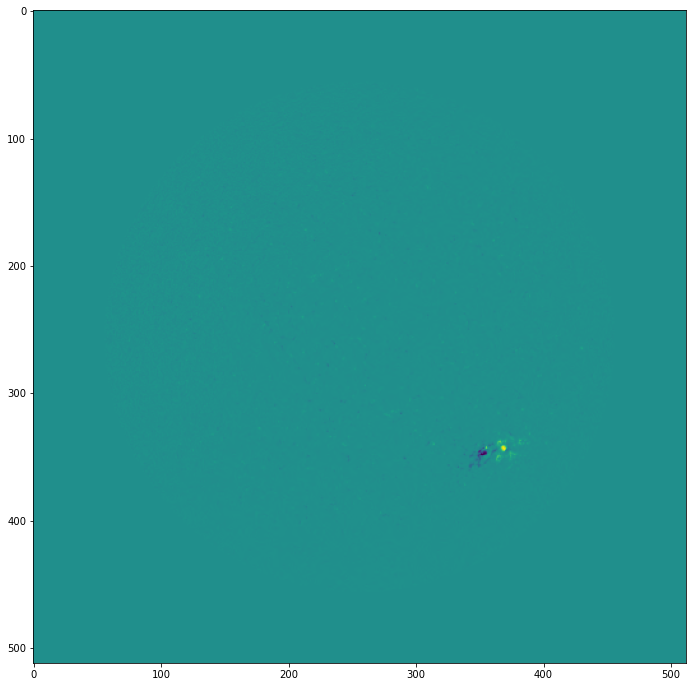

In [7]:
plt.figure(figsize=(12, 12))
plt.imshow(t);

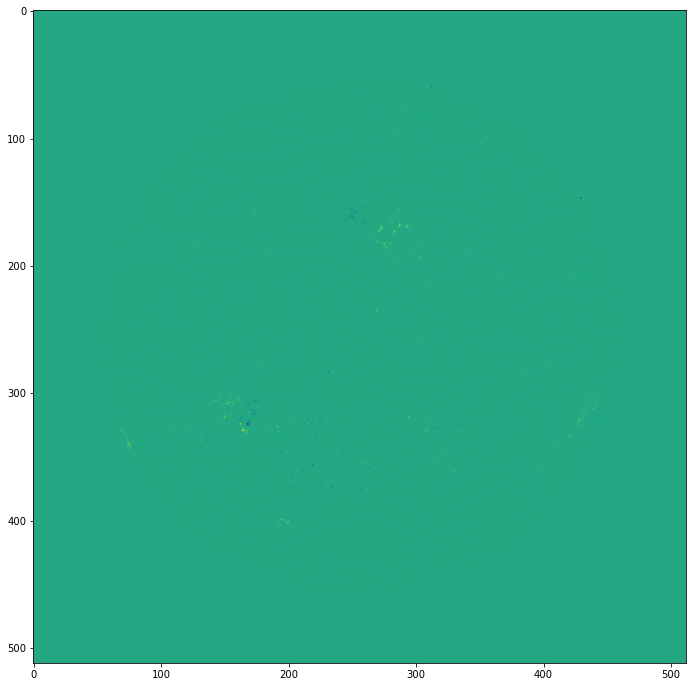

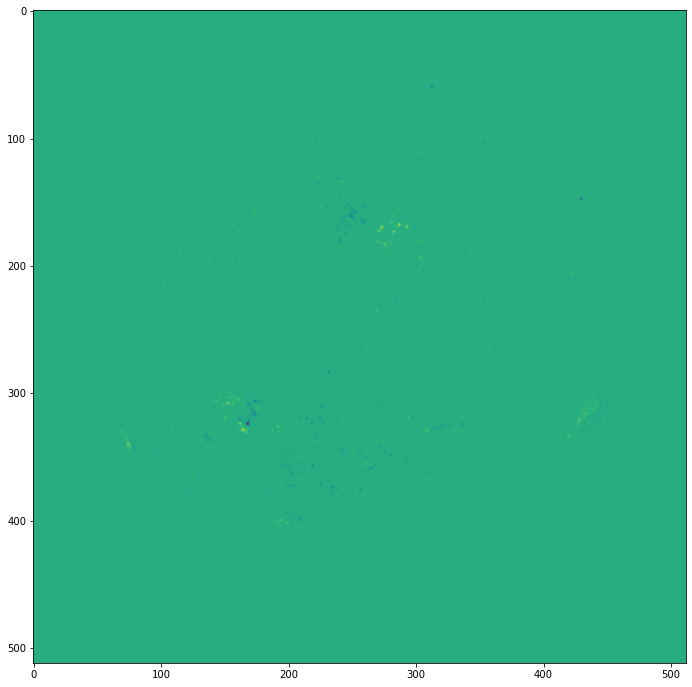

In [15]:
dfile1 = "/data1/data/sdo-dataset/Bz/2010/05/01/HMI20100501_0012_bz.npz"
dfile2 =          "/data2/sdomlv2/Bz/2010/05/01/HMI20100501_0012_bz.npz"
images1 = np.load(dfile1)["x"].astype(np.float64)
plt.figure(figsize=(12, 12))
# plt.imshow(images, cmap='gray');
plt.imshow(images1);

images2 = np.load(dfile2)["x"].astype(np.float64)
plt.figure(figsize=(12, 12))
# plt.imshow(images, cmap='gray');
plt.imshow(images2);

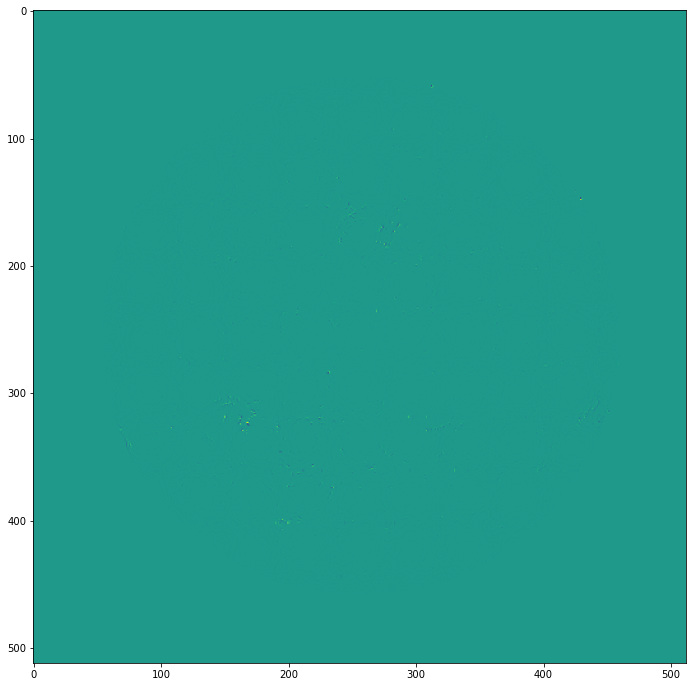

In [14]:
plt.figure(figsize=(12, 12))
plt.imshow(images1-images2)

In [3]:
channel = "bz"
base_resize = 512
resize = 128
classes_bin = [
    {"Quiet": "< 1e-6"},
    {">=C": ">= 1e-6"},
]

transform = (
    SDOSimCLRDataTransform(
        128,
        do_online_transform=True,
        transform_before=transforms.CenterCrop((base_resize // 2, base_resize - base_resize // 8)),
        transform_after=sdo_dataset_normalize(channel),
        min_scale_resize=0.2,
        max_scale_resize=0.9,
    ),
    SDOSimCLRDataTransform(
        128,
        do_online_transform=True,
        transform_before=transforms.CenterCrop((base_resize // 2, base_resize - base_resize // 8)),
        # transform_after=sdo_dataset_normalize(parameters["data"]["channel"]),
    ),
)

dm = SDODatasetDataModule(
    Path("../data/sdo-dataset-ssl-bz-1h-month"),
    transform=transform,
    target_transform=flux_to_class_builder(classes_bin),
    batch_size=768,
    num_workers=20,
)
dm.setup()

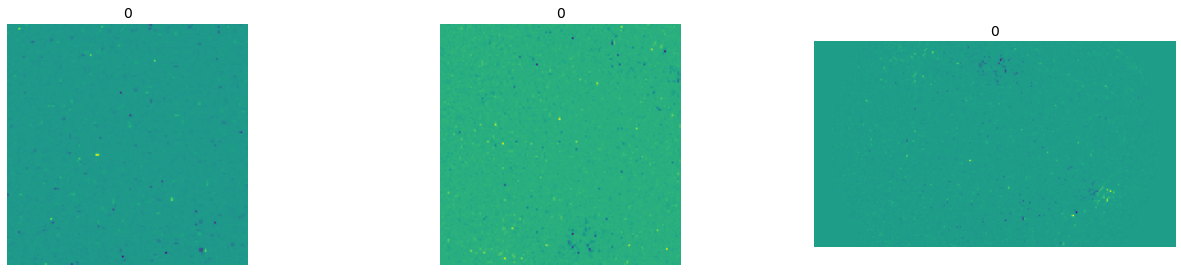

In [4]:
sample_id = 0
img_data_id = 0

samples = [i[0] for i in dm.dataset_train[sample_id][img_data_id]]

plot_image_grid(samples, [0,0,0], columns=3, height=10)

In [5]:
n_channel = 1
n_class = 2
epochs = 5
lr = 1e-4
classes_bin = [
    {"Quiet": "< 1e-6"},
    {">=C": ">= 1e-6"},
]
datamodule = SDOBenchmarkDataModule(
            Path("../data/sdo-benchmark"),
            batch_size=32,
            validation_size=0.1,
            channel="171",
            resize=128,
            seed=42,
            num_workers=20,
            target_transform=flux_to_class_builder(classes_bin),
            time_steps=3,
        )
datamodule.setup()
datamodule.size()

(1, 128, 128)

In [16]:
store = zarr.DirectoryStore(Path("/data2/sdomlv2_full/sdomlv2_hmi.zarr/"))
cache = zarr.LRUStoreCache(store, max_size=10*1000*1000*1000)
root = zarr.open(store=cache, mode='r')
# root = zarr.group(store)

# cache = zarr.LRUStoreCache(store, max_size=cache_max_size)
# root = zarr.open(store=cache, mode='r')

# root = root["2019"]["Bz"]

# print(root.tree())
# t_obs = np.array(root.attrs["T_OBS"])
# t_obs

In [9]:
# import gcsfs
# gcs = gcsfs.GCSFileSystem(access="read_only")
# loc = "fdl-sdoml-v2/sdomlv2.zarr/"
# store = gcsfs.GCSMap(loc, gcs=gcs, check=False)
# root = zarr.group(store)
# print(root.tree())

In [47]:
da.from_array(root)[0, :, :]

AttributeError: 

<sunpy.map.mapbase.GenericMap object at 0x7fba84a93ca0>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 HMI SIDE1
Detector:		 HMI
Measurement:		 6173.0 Angstrom
Wavelength:		 6173.0 Angstrom
Observation Date:	 2010-05-01 00:10:22
Exposure Time:		 0.000000 s
Dimension:		 [512. 512.] pix
Coordinate System:	 helioprojective
Scale:			 [4.68474621 4.68474621] arcsec / pix
Reference Pixel:	 [255.5 255.5] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
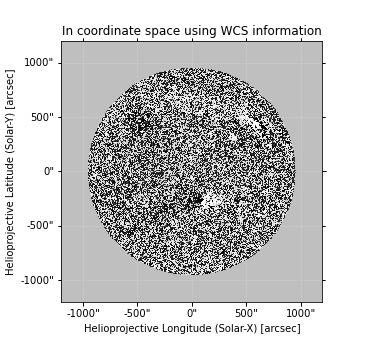
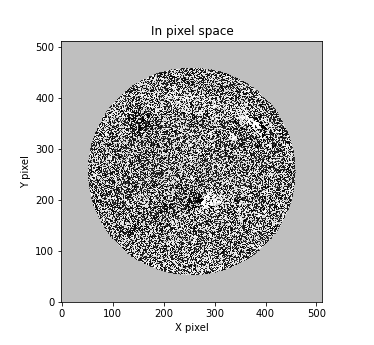
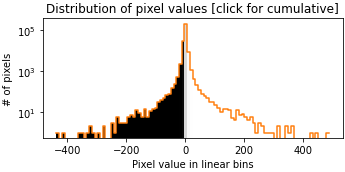
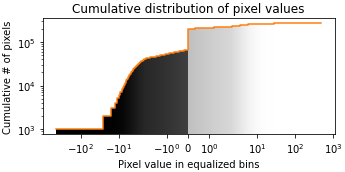

In [28]:
selected_image = da.from_array(root)[1000, :, :]
selected_headr = {keys: values[0] for keys, values in root.attrs.items()}
selected_headr['WAVEUNIT'] = 'angstrom'
my_map = sunpy.map.Map((np.array(selected_image), selected_headr))
my_map

In [29]:
t=torch.as_tensor(selected_image.compute())

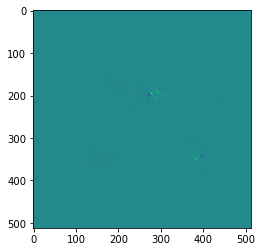

In [30]:
plt.imshow(t);

## `.zarr` to `.npz`

In [21]:
def f(dataset_path: Path, destination: Path, channel: str, instrument: str, max_cache_size_bytes: int = 10_000_000_000):
    store = zarr.DirectoryStore(dataset_path)
    cache = zarr.LRUStoreCache(store, max_size=max_cache_size_bytes)
    root = zarr.open(store=cache, mode='r')

    years = [str(y) for y in range(2010, 2021)]

    for year in tqdm(years):
        data = root[year][channel]
        obs_times = data.attrs["T_OBS"]

        for t in obs_times:
            try:
                obs_time = datetime.strptime(t, "%Y.%m.%d_%H:%M:%S_TAI")
            except:
                t = t[:-7]
                obs_time = datetime.datetime.strptime(t, "%Y.%m.%d_%H:%M")
                obs_time += datetime.timedelta(minutes=1)

                # print(t)
                # d, tm = t[:-4].split("_")
                # h,m,s = tm.split(":")
                # h = int(h)
                # m = int(m) + 1
                # if m == 60:
                #     m = 0
                #     h += 1
                # if h == 24:
                    
                # new_time = f"{d}_{h:02d}:{m:02d}:00"
                # try:
                #     obs_time = datetime.strptime(new_time, "%Y.%m.%d_%H:%M:%S")
                # except:
                #     print(new_time)
                    # ts = t[:-4].split(":")
                    # new_time = ":".join([ts[0], f"{int(ts[1]) + 1:02d}", "00"])
                # return

        # Loop on all samples
        # for i, sample in enumerate(tqdm(data)):
        #     # Get OBS time
        #     obs_time = obs_times[i]
        #     obs_time = datetime.strptime(obs_time, "%Y.%m.%d_%H:%M:%S_TAI")
            
        #     # Create path
        #     str_datetime = obs_time.strftime("%Y%m%d_%H%M")
        #     year = str(obs_time.year)
        #     month = f"{obs_time.month:02d}"
        #     day = f"{obs_time.day:02d}"
        #     filepath = destination / channel / year / month / day / f"{instrument}{str_datetime}_{channel.lower()}.npz"

        #     # Save to path
        #     filepath.parent.mkdir(parents=True, exist_ok=True)
        #     np.savez_compressed(filepath, x=sample)

dataset_path = Path("/data2/sdomlv2_full/sdomlv2_hmi.zarr/")
destination = Path("/data2/sdomlv2/")
f(dataset_path, destination, "Bz", "HMI")

  0%|          | 0/11 [00:00<?, ?it/s]

In [12]:
array = da.from_array(root)
array

dask.array<array, shape=(25540, 512, 512), dtype=float32, chunksize=(120, 512, 512), chunktype=numpy.ndarray>

In [20]:
import datetime
# t = "2010.10.04_17:11:60_TAI"
t = "2010.10.04_17:11"
# ts = t[:-4].split(":")
# ":".join([ts[0], f"{int(ts[1]) + 1:02d}", "00"])
obs_time = datetime.datetime.strptime(t, "%Y.%m.%d_%H:%M")
obs_time + datetime.timedelta(minutes=1)

datetime.datetime(2010, 10, 4, 17, 12)

In [17]:
years = [str(y) for y in range(2010, 2021)]
for year in years:
    data = root[year]["Bz"]
    a=[t for t in data.attrs["T_OBS"]]# if t.startswith("2019.06.21")]
    print(len(a),len(set(a)))

25540 25540
40086 40086
40172 40172
38540 38540
40590 40590
40490 40490
40452 40452
40976 40976
40475 40475
40807 40807
41001 41001


In [19]:
print(root.tree())

/
 ├── 2010
 │   ├── Bx (25540, 512, 512) float32
 │   ├── By (25540, 512, 512) float32
 │   └── Bz (25540, 512, 512) float32
 ├── 2011
 │   ├── Bx (40086, 512, 512) float32
 │   ├── By (40086, 512, 512) float32
 │   └── Bz (40086, 512, 512) float32
 ├── 2012
 │   ├── Bx (40172, 512, 512) float32
 │   ├── By (40172, 512, 512) float32
 │   └── Bz (40172, 512, 512) float32
 ├── 2013
 │   ├── Bx (38540, 512, 512) float32
 │   ├── By (38540, 512, 512) float32
 │   └── Bz (38540, 512, 512) float32
 ├── 2014
 │   ├── Bx (40590, 512, 512) float32
 │   ├── By (40590, 512, 512) float32
 │   └── Bz (40590, 512, 512) float32
 ├── 2015
 │   ├── Bx (40490, 512, 512) float32
 │   ├── By (40490, 512, 512) float32
 │   └── Bz (40490, 512, 512) float32
 ├── 2016
 │   ├── Bx (40452, 512, 512) float32
 │   ├── By (40452, 512, 512) float32
 │   └── Bz (40452, 512, 512) float32
 ├── 2017
 │   ├── Bx (40976, 512, 512) float32
 │   ├── By (40976, 512, 512) float32
 │   └── Bz (40976, 512, 512) float32
 ├── 2